# Akademi (Flatiron School) — Data Science & AI, Cohorte 2025

# Second Project – Phase 2

**Student Name**: Micka LOUIS  
**Student Pace**: Self-paced  
**Submission Deadline**: July 20, 2025  
**Instructors' Names**: Wedter JEROME & Geovany Batista Polo LAGUERRE  
**Blog Post URL**: https://github.com/Micka-Louis/dsc-project-phase-2.git 

# **Project Title**

# Box Office Success: A Statistical Approach
![Cover](images/imag1.jpg)

# Overview 
This project aims to help a company understand what types of films to produce as part of launching a new film studio. We will analyze data from multiple sources to formulate three concrete business recommendations.

# Business Understanding & Business Problem
![Cover](images/imag2.jpg)
Before investing in a first film, the company wants to minimize risk by relying on evidence, based analysis drawn from historical data. It seeks to understand which genres are the most profitable, whether a film’s duration impacts its revenue, whether highly rated films attract more viewers, if there's a link between popularity (measured by the number of votes) and financial success, or whether certain production formats, such as feature films, should be prioritized.

This project aims to turn past data into future decisions by providing the studio with concrete and measurable insights to help it choose the right kind of films to produce.

The business problem can be formulated as follows:  
How can a new film production company maximize its chances of box office success by intelligently choosing the characteristics of the films it produces?  

To address this question, it is necessary to:  

- identify the factors statistically associated with financial success (e.g., revenue),

- measure the strength of the relationships between these factors (duration, rating, genre, votes, etc.) and box office performance,

- and formulate operational and strategic recommendations to guide the studio's early production decisions.



# 1-Data Understanding 
To meet the objectives of the analysis, we rely on **three main data sources**:

1. **Box Office Mojo (`bom.movie_gross.csv.gz`)** – This dataset provides essential financial information such as domestic and international gross revenue, movie titles, release groups, and studios.

2. **The Numbers (`tn.movie_budgets.csv.gz`)** – This source adds **budget data**, including production budgets and total worldwide gross, enabling us to analyze the relationship between investment and return.

3. **IMDb (`IMDb movies.csv` or equivalent)** – This dataset includes critical reception indicators such as **average viewer ratings**, **number of votes**, **genre**, **runtime**, and **type of film** (e.g., feature film, TV series).

These datasets were merged based on relevant keys like the **movie title** and **release type**, providing an enriched and unified view of each film. This combined perspective allows us to study the **commercial performance**, **viewer perception**, and **production context** simultaneously.

This understanding phase allows us to:
- Identify relevant variables for the business problem (e.g., gross revenue, rating, budget, genre),
- Evaluate data quality (missing values, duplicates, inconsistent formats),
- Detect potential issues before deeper statistical analysis and modeling.



## **1.1 Importing Required Libraries**

In [1]:
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
import sqlite3
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

import pickle

## **1.2 Connect to the Database**

In [2]:
conn = sqlite3.connect('data/im.db')

##  1.3 Write a query to return all the tables in the database

In [3]:
df = pd.read_sql(
    """
    SELECT *
    FROM sqlite_master
    """
, conn
)

df[df['type'] == 'table']

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


## 1.4 📥 Loading Financial Data

In [4]:
# 📥 Loading The Numbers data (production budgets and worldwide revenues)
df1= pd.read_csv("data/tn.movie_budgets.csv.gz", encoding="ISO-8859-1", low_memory=False)

## 1.5 Initial Exploration and Data Quality Assessment(movie_budgets)

In [6]:
#Display the first 5 rows of the dataset
df1.head(5)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [83]:
#Display the names of all available columns in the DataFrame
df1.columns

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')

In [84]:
#Display the number of rows and columns in the dataset
df1.shape

(5782, 6)

In [85]:
#Display the number of missing values per column, sorted in descending order
df1.isnull().sum().sort_values(ascending=False)

worldwide_gross      0
domestic_gross       0
production_budget    0
movie                0
release_date         0
id                   0
dtype: int64

In [86]:
#Check how many rows are completely duplicated in the DataFrame
df1.duplicated().sum()

0

The dataset from The Numbers (`df1`) contains 5,782 entries and 6 columns, including movie ID, release date, movie title, production budget, domestic gross, and worldwide gross. df1 is complete with no missing values or duplicate rows, ensuring high data integrity. It provides detailed financial information covering both the production costs and the box office revenues at domestic and global levels. This makes `df1` a valuable source for analyzing the profitability and financial performance of films.

# 2-Data Preparation 

## 2.0 Cleaning and Enriching df1

In [5]:
# Remove dollar signs and commas, then convert to integers
columns_to_clean = ['production_budget', 'domestic_gross', 'worldwide_gross']
for col in columns_to_clean:
    df1[col] = df1[col].replace('[\$,]', '', regex=True).astype('float')

# Create foreign_gross = worldwide_gross - domestic_gross
df1['foreign_gross'] = df1['worldwide_gross'] - df1['domestic_gross']

# Add a 'profit' column by calculating the difference
df1['profit'] = df1['worldwide_gross'] - df1['production_budget']


# Convert release_date to datetime
df1['release_date'] = pd.to_datetime(df1['release_date'])

# Extract year from release_date
df1['year'] = df1['release_date'].dt.year

# Extract the month from the release date
df1['month'] = df1['release_date'].dt.month

# Define a function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Unknown'

# Create the 'season' column using the mapping function
df1['season'] = df1['month'].apply(get_season)

# 2.1-IMDB Dataset

![cover](images/imag3.jpeg)

To enrich the financial analysis of films, we leverage the `IMDB` database, renowned for its rich information on cinema. Among the various available tables, we have selected `movie_basics` and `movie_ratings`, two central tables for our problem. The `movie_basics` table contains key descriptive information about films, such as unique identifiers, title, release year, genre, and film type. These data are essential to characterize each film and understand its context. The `movie_ratings` table provides critical data, including the average viewer rating and the number of votes, which are important indicators of a film’s popularity and perceived quality. By combining these two sources via the film identifier, we obtain a comprehensive dataset that allows us to study not only financial performance (from other sources) but also critical reception and audience appeal. This choice aligns with our project’s objective: to identify which factors related to film characteristics and popularity influence box-office success, thereby guiding the decisions of a new studio.

## 2.2 Sample Query and Preview of `movie_basics` Table

In [6]:
# Execute a SQL query to retrieve the all rows from the 'movie_basics' table
query1 = """SELECT * FROM movie_basics;"""

# Load the query results into a pandas DataFrame
df_basics = pd.read_sql_query(query1, conn)

# Display the first 5 rows of the DataFrame
df_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [7]:
#Display the names of all available columns in the DataFrame
print(f"The names of all available columns: {df_basics.columns}")

#Display the number of rows and columns in the dataset
print(f"The number of rows and columns: {df_basics.shape}")

The names of all available columns: Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres'],
      dtype='object')
The number of rows and columns: (146144, 6)


In [8]:
#Display the number of missing values per column, sorted in descending order
print("The number of missing values per column:")
print(df_basics.isnull().sum().sort_values(ascending=False))

#Check how many rows are completely duplicated in the DataFrame
print(f"Number of duplicated rows: {df_basics.duplicated().sum()}")

The number of missing values per column:
runtime_minutes    31739
genres              5408
original_title        21
start_year             0
primary_title          0
movie_id               0
dtype: int64
Number of duplicated rows: 0


The movie_basics table contains essential descriptive information on 146,144 films, with six key columns: a unique identifier (movie_id), the primary title (primary_title), the original title (original_title), the release year (start_year), the runtime in minutes (runtime_minutes), and the associated genres (genres). A simple SQL query allows retrieving all this data into a pandas DataFrame for exploration. Initial analysis reveals some missing values, notably for the runtime (31,739 null entries) and genres (5,408 null entries), while the other columns are complete. No full duplicates were detected in this table, ensuring data integrity. This overview helps better understand the structure and quality of the available data, which is an essential prerequisite before any deeper analysis.

## 2.3 Sample Query and Preview of `movie_ratings` Table

In [9]:
# Execute a SQL query to retrieve the all rows from the 'movie_ratings' table
query2 = """SELECT * FROM movie_ratings;"""

# Load the query results into a pandas DataFrame
df_ratings = pd.read_sql_query(query2, conn)

# Display the first 5 rows of the DataFrame
df_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [10]:
#Display the names of all available columns in the DataFrame
print(f"The names of all available columns: {df_ratings.columns}")

#Display the number of rows and columns in the dataset
print(f"The number of rows and columns: {df_ratings.shape}")

The names of all available columns: Index(['movie_id', 'averagerating', 'numvotes'], dtype='object')
The number of rows and columns: (73856, 3)


In [11]:
#Display the number of missing values per column, sorted in descending order
print("The number of missing values per column:")
print(df_ratings.isnull().sum().sort_values(ascending=False))

#Check how many rows are completely duplicated in the DataFrame
print(f"The number of duplicated rows: {df_ratings.duplicated().sum()}")

The number of missing values per column:
numvotes         0
averagerating    0
movie_id         0
dtype: int64
The number of duplicated rows: 0


The movie_ratings table provides critical information on the reception of films, with a total of 73,856 entries covering three columns: the movie identifier (movie_id), the average user rating (averagerating), and the total number of votes (numvotes). A full extraction via SQL allows loading this data into a pandas DataFrame for thorough exploration. Initial inspection shows that this table contains no missing values or duplicates, thus ensuring data reliability for subsequent analyses. This information is essential to study the impact of a film’s popularity and perceived quality on its commercial success.

## 2.4 Cleaning Invalid Values in Categorical Variables (`genres`)


In [12]:
categorical_cols = ['genres']


invalid_values = ['Unknown', 'Unavailable', 'None', 'UNK', 'unknown', 'ANAVAILABLE', 'NONE', 'none',\
                 'unk', 'n/a', 'N/A', 'Unk', 'UNKNOWN','']

for col in categorical_cols:
    mode = df_basics[col].mode()[0]
    df_basics[col] = df_basics[col].replace(invalid_values, np.nan)
    df_basics[col].fillna(mode, inplace=True) 
    
df_basics.isnull().sum()

movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres                 0
dtype: int64

### Cleaning the `genres` Column: Keeping Only the Primary Genre

In [13]:
# Keep only the first genre from the 'genres' column
# Step-by-step:
# 1. Split the string by commas (e.g., "Drama, Comedy" → ["Drama", "Comedy"])
# 2. Select the first genre in the list (index 0)
# 3. Remove any leading/trailing spaces from the result

df_basics['genres'] = df_basics['genres'].str.split(',').str[0].str.strip()

## 2.5 Imputation of missing values for numerical variable**

In [14]:
# Fill missing 'runtime_minutes' values within each genre group using the median runtime of that genre
df_basics['runtime_minutes'] = df_basics.groupby('genres')['runtime_minutes'].transform(lambda x: x.fillna(x.median()))

# For any remaining missing values in 'runtime_minutes' (e.g., genres with all missing runtimes), fill with the overall median runtime
df_basics['runtime_minutes'] = df_basics['runtime_minutes'].fillna(df_basics['runtime_minutes'].median())

# Display the count of missing values per column after imputation
df_basics.isnull().sum()

movie_id            0
primary_title       0
original_title     21
start_year          0
runtime_minutes     0
genres              0
dtype: int64

The runtime_minutes column initially contained many missing values (31,739), which we addressed using a two-step imputation: first, by filling missing values with the median runtime within each genre to preserve genre-specific characteristics; then, by using the overall median for any remaining cases. As for the original_title column, it had 21 missing values, but these are not truly missing since they are available in the df1 table and can be retrieved via the movie_id key. Thus, no imputation is required, and data integrity is maintained through cross-referencing.

## 2.6 Data Integration: Merging Financial, Descriptive, and Rating Datasets

In [15]:
# Function to normalize movie titles by lowercasing, removing punctuation and extra spaces
def normalize_title(title):
    if pd.isna(title):
        return ""  # Return empty string if the title is missing
    title = title.lower()                    # Convert to lowercase
    title = re.sub(r'[^\w\s]', '', title)    # Remove punctuation
    title = re.sub(r'\s+', ' ', title)       # Replace multiple spaces with a single space
    title = title.strip()                    # Remove leading and trailing spaces
    return title

# Apply normalization to movie titles in both DataFrames
df1['movie_norm'] = df1['movie'].apply(normalize_title)
df_basics['primary_title_norm'] = df_basics['primary_title'].apply(normalize_title)

In [16]:
df_merged = pd.merge(df1, df_basics,
                     left_on='movie_norm',
                     right_on='primary_title_norm',
                     how='inner',   # keep only exact matches
                     suffixes=('_df1', '_basics'))

print(f"Number of films after merging df1 and movie_basics: {df_merged.shape[0]}")

Number of films after merging df1 and movie_basics: 4002


In [17]:
df_final = pd.merge(df_merged, df_ratings,
                    left_on='movie_id',
                    right_on='movie_id',
                    how='inner')  # keep only films present in both datasets

print(f"Number of films after merging with movie_ratings: {df_final.shape[0]}")

Number of films after merging with movie_ratings: 3006


In [100]:
# Display the first 5 rows of the df_final
df_final.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,foreign_gross,profit,year,month,...,movie_norm,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,primary_title_norm,averagerating,numvotes
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2.015838e+09,2.351345e+09,2009,12,...,avatar,tt1775309,Avatar,Abatâ,2011,93.0,Horror,avatar,6.1,43
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,8.046000e+08,6.350639e+08,2011,5,...,pirates of the caribbean on stranger tides,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.0,Action,pirates of the caribbean on stranger tides,6.6,447624
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,1.070000e+08,-2.002376e+08,2019,6,...,dark phoenix,tt6565702,Dark Phoenix,Dark Phoenix,2019,113.0,Action,dark phoenix,6.0,24451
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,9.440081e+08,1.072414e+09,2015,5,...,avengers age of ultron,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.0,Action,avengers age of ultron,7.3,665594
4,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,1.369319e+09,1.748134e+09,2018,4,...,avengers infinity war,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,Action,avengers infinity war,8.5,670926


In [18]:
# We select the columns to drop: either redundant or not useful
columns_to_drop = [
    'primary_title',         # same as 'movie'
    'original_title',
    'primary_title_norm',        # also similar
    'start_year',            # same as 'year'
    'movie_norm',            # duplicate of 'primary_title_norm'
]

# Drop the selected columns
df_clean = df_final.drop(columns=columns_to_drop)

# Check the result
print(df_clean.columns)
print(df_clean.shape)
df_clean.head()

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'foreign_gross', 'profit', 'year', 'month', 'season',
       'movie_id', 'runtime_minutes', 'genres', 'averagerating', 'numvotes'],
      dtype='object')
(3006, 16)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,foreign_gross,profit,year,month,season,movie_id,runtime_minutes,genres,averagerating,numvotes
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2.015838e+09,2.351345e+09,2009,12,Winter,tt1775309,93.0,Horror,6.1,43
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,8.046000e+08,6.350639e+08,2011,5,Spring,tt1298650,136.0,Action,6.6,447624
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,1.070000e+08,-2.002376e+08,2019,6,Summer,tt6565702,113.0,Action,6.0,24451
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,9.440081e+08,1.072414e+09,2015,5,Spring,tt2395427,141.0,Action,7.3,665594
4,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,1.369319e+09,1.748134e+09,2018,4,Spring,tt4154756,149.0,Action,8.5,670926


In [102]:
#Remove any spaces from the result
df_clean.columns = df_clean.columns.str.strip().str.lower()

# Display the count of missing values per column after merging
df_clean.isnull().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
foreign_gross        0
profit               0
year                 0
month                0
season               0
movie_id             0
runtime_minutes      0
genres               0
averagerating        0
numvotes             0
dtype: int64

To construct a clean, unified dataset integrating financial figures, movie metadata, and audience ratings, we carried out a structured data integration process. The first step involved standardizing movie titles across datasets: both the financial dataset (`df1`) and the `IMDb` descriptive dataset (`df_basics`) underwent title normalization, which included converting titles to lowercase, stripping punctuation, and reducing multiple spaces. This normalization was essential to ensure consistent matching despite variations in formatting.

Following this, we merged the financial and descriptive datasets using inner joins on the normalized titles, preserving only exact matches to maintain data reliability. This operation yielded 4,002 matched records, aligning movies from the two independent sources.

Next, we further enriched this merged dataset by integrating `IMDb` ratings (`df_ratings`) based on the unique movie identifier (`movie_id`). Again, an inner join was used to ensure that only movies with available rating information were retained, resulting in a final dataset of 3,006 films.

To streamline the dataset and eliminate redundancy, we removed duplicate or unnecessary columns such as the original titles, normalized keys, and overlapping year fields. The resulting dataset includes financial indicators (budgets, revenues, profits), descriptive attributes (release dates, genres, runtimes), and audience reception data (ratings and vote counts).

This cleaned and enriched dataset ensures high consistency and completeness across all variables, providing a robust foundation for reliable exploratory analysis, hypothesis testing, and predictive modeling.

## 2.7 Export Cleaned Dataset to CSV

In [19]:
# Export the cleaned DataFrame to CSV
df_clean.to_csv("df_clean_export.csv", index=False)

## 3-Analysis and Results

In this section, we present the exploratory data analysis (EDA) and the main findings of our study. The goal is to identify key patterns, correlations, and factors that may influence a film’s profitability. Through descriptive statistics, visualizations, and statistical tests, we aim to build a solid understanding of the data before proceeding to predictive modeling.

### 3.0 Summary of numerical variables

In [77]:
# Summary tables
df_clean.describe()

,id,production_budget,domestic_gross,worldwide_gross,foreign_gross,profit,year,month,runtime_minutes,averagerating,numvotes
count,3006.000000,3.006000e+03,3.006000e+03,3.006000e+03,3.006000e+03,3.006000e+03,3006.000000,3006.000000,3006.000000,3006.000000,3.006000e+03
mean,50.985695,3.415028e+07,4.304762e+07,1.024793e+08,5.943170e+07,6.832905e+07,2010.320027,6.972721,102.339654,6.249900,6.551423e+04
std,28.652734,4.741874e+07,7.426241e+07,2.020387e+08,1.338539e+08,1.678678e+08,9.221442,3.516151,20.545572,1.187665,1.328346e+05
min,1.000000,1.400000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-2.002376e+08,1915.000000,1.000000,3.000000,1.600000,5.000000e+00
25%,27.000000,5.000000e+06,5.017520e+05,2.351108e+06,9.111600e+04,-2.302890e+06,2010.000000,4.000000,90.000000,5.600000,1.352500e+02
50%,51.000000,1.700000e+07,1.679261e+07,3.037390e+07,9.741772e+06,1.005956e+07,2013.000000,7.000000,100.000000,6.400000,7.640000e+03
75%,76.000000,4.000000e+07,5.186765e+07,1.011621e+08,5.293466e+07,6.271639e+07,2015.000000,10.000000,113.000000,7.100000,7.477100e+04
max,100.000000,4.250000e+08,7.605076e+08,2.776345e+09,2.015838e+09,2.351345e+09,2019.000000,12.000000,280.000000,9.400000,1.841066e+06


The descriptive analysis of numerical variables reveals substantial financial variability among the films studied. The average production budget is approximately 34 million USD, with a high standard deviation, indicating significant disparities between independent films and major productions. Worldwide gross revenues vary widely, with a median around 30 million but a much higher mean of 102 million, reflecting the presence of blockbuster hits that skew the average upwards. The median profit is about 10 million, while losses reaching as much as (–200) million are observed, highlighting cases of commercial failure.

From a temporal perspective, the dataset covers films from 1915 to 2019, with a concentration primarily in the 2010s and a median release month of July (summer in the United States). Regarding seasons, the distribution suggests patterns that can be further explored in bivariate analysis, particularly to test whether summer releases are indeed more profitable than those launched in winter or spring.

For other variables, the average runtime is 102 minutes, the average IMDb rating is 6.2/10, indicating moderate perceived quality, and the number of votes ranges dramatically (from 5 to over 1.8 million), reflecting large differences in popularity and visibility.

## 3.1 Univariate Analysis  
We analyze the distribution of key variables in the dataset, such as `profit`, `genres`, `year`, `season`, and `runtime_minutes`. This helps identify overall trends, outliers, and how the observations are distributed.

`profit`: To understand the distribution of film profitability.

`genres`: To identify the most common or dominant genres.

`year`: To examine temporal trends in film production and release.

`season`: To observe how film releases are distributed across different seasons.

`runtime_minutes`: To analyze the typical duration of films and detect unusually short or long runtimes.  

### Distribution of profit

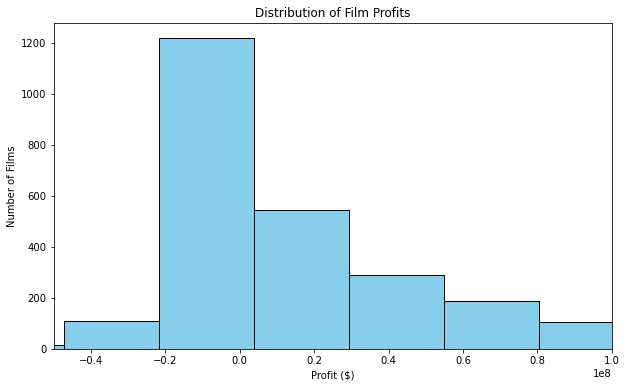

In [20]:
# Profit distribution
plt.figure(figsize=(10,6))
plt.hist(df_clean['profit'], bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Film Profits')
plt.xlabel('Profit ($)')
plt.ylabel('Number of Films')
plt.xlim(-50000000, 100000000)  # zoom
plt.show()

The graph above illustrates the distribution of film profits in our database. Most films fall within a relatively low profit range, between 0 and 50 million dollars. A strong right skew is also observed, indicating that a small number of films generate exceptionally high profits, while others even incur losses (negative profit). This representation highlights the high heterogeneity of the film market: although some productions achieve significant commercial success, a substantial proportion of films struggle to break even. This observation reinforces the relevance of our study, which aims to model the factors influencing profit in order to provide informed recommendations to a new film production company.

### Distribution of Genres 

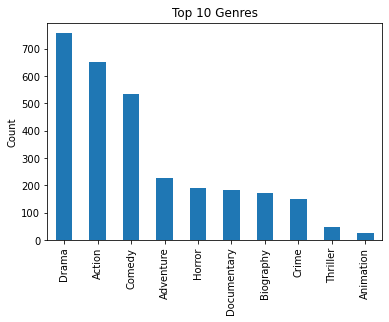

In [21]:
# Genre frequency
df_clean['genres'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Genres')
plt.ylabel('Count')
plt.show()

The chart above displays the top 10 most common movie genres in our dataset. The Drama genre clearly dominates with approximately 750 films, reflecting its strong presence in the film industry. It is followed by Action with around 650 films, and Comedy, which appears in about 530 films.

Other notable genres include Adventure about 230, Horror about 190, Documentary about 185, Biography about 170, Crime about 150, Thriller about 50, and Animation about 30. This distribution highlights the dominance of dramatic, action-packed, and comedic content, which are likely aligned with audience preferences and production trends.

In the context of our study “Box Office Success: A Statistical Approach,” these findings offer valuable insight into genre popularity and could inform strategic decisions regarding future film productions.

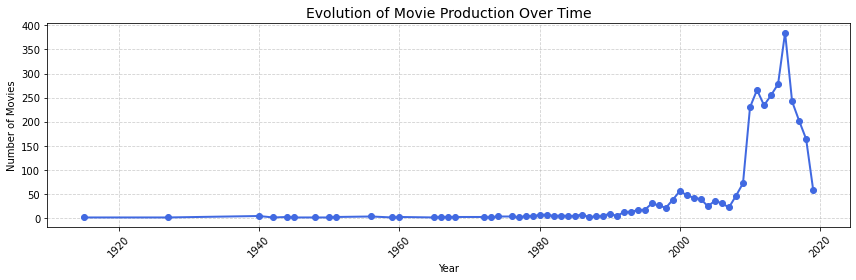

In [22]:
# Step 1: Group by year and count the number of films
movies_per_year = df_clean['year'].value_counts().sort_index()

# Step 2: Plot the trend over time
plt.figure(figsize=(12, 4))
plt.plot(movies_per_year.index, movies_per_year.values, marker='o', color='royalblue', linewidth=2)

plt.title('Evolution of Movie Production Over Time', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

This graph represents the number of films produced each year in the studied sample. A relatively moderate growth can be observed until the early 2000s, followed by a sharp increase starting around 2005. The peak is reached around 2016, with a number of releases significantly higher than in previous decades. This rise can be attributed to several factors, such as the democratization of production tools, the growing influence of streaming platforms, and increased diversification of film formats. However, a slight decline is noticeable after 2018, possibly linked to industrial or economic disruptions, such as the COVID-19 pandemic beginning in 2020. This trend is crucial to consider in production planning, as it reflects the evolving landscape of competition and opportunities in the film market.

### Distribution of Movies by season

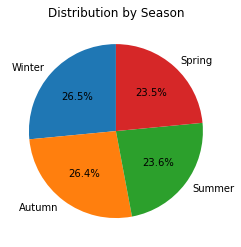

In [23]:
# Movies by season
df_clean['season'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution by Season')
plt.ylabel('')
plt.show()

The pie chart illustrates the distribution of film releases across the seasons. We observe a relatively balanced distribution among the four seasons. Autumn (26.4%) and Winter (26.5%) account for slightly more releases, while Spring (23.5%) and Summer (23.6%) have slightly fewer. This distribution suggests a release strategy spread throughout the year, with a slight preference for the end of the year, a period generally favorable for high-potential films (blockbusters, year-end releases, awards contenders, etc.). These data can help identify the optimal release periods to maximize a film’s visibility and revenue.

### 📊 Distribution of Movie Runtimes (in Minutes)

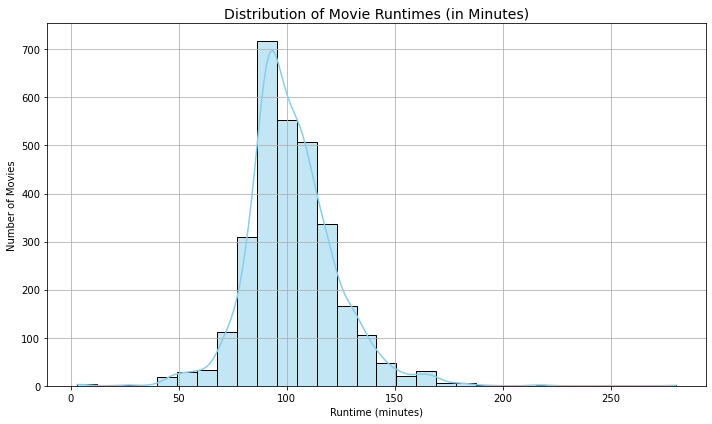

In [24]:
# Plotting the histogram of movie runtimes
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['runtime_minutes'], bins=30, kde=True, color='skyblue')

# Adding titles and labels
plt.title("Distribution of Movie Runtimes (in Minutes)", fontsize=14)
plt.xlabel("Runtime (minutes)")
plt.ylabel("Number of Movies")
plt.grid(True)
plt.tight_layout()
plt.show()

The chart shows the distribution of movie durations (in minutes) in the dataset. A marked concentration can be observed around 95 to 100 minutes, which corresponds to the most frequent duration, indicating that the majority of films have a standard length between 85 and 115 minutes. The distribution is slightly skewed to the right, with a few longer films exceeding 140 minutes, although these remain in the minority. The overlaid density curve confirms a unimodal distribution, with no clear break between different types of films. This suggests that most productions follow a standard duration of around 1.5 to 2 hours, which serves as a relevant benchmark for planning future projects.

## 3.2 Bivariate Analysis
The goal here is to explore relationships between pairs of variables. For example:

- profit vs averagerating: Are higher-rated films more profitable?

- profit vs season: Are some seasons more profitable than others?

- profit vs numvotes: Do more popular films generate higher profits?

- Profit vs Genre: which genres tend to be more or less profitable?

The "Profit vs Average Rating" scatter plot illustrates the relationship between a film’s average IMDb rating (x-axis) and its profit in dollars (y-axis). This visualization directly aligns with our project theme, "Box Office Success: A Statistical Approach."

From the graph, we notice that most movies with ratings between 6 and 8 tend to achieve significant positive profits, although with considerable variability. This suggests that well-rated films are more likely to succeed at the box office, but the rating alone is not a definitive predictor of profitability. Some highly rated films still result in losses, while a few lower-rated films manage to generate substantial profits.

Additionally, there is a large cluster of films showing low or zero profits, regardless of their IMDb ratings. This emphasizes that beyond audience reception (as measured by ratings), factors like production budget, marketing strategies, distribution scale, and release timing are critical in determining a film's box office success.

Thus, this scatter plot serves as an initial insight, indicating the need for a more comprehensive multivariate analysis, such as multiple linear regression, to better understand the statistical drivers of box office success.

### Profit vs Average Rating

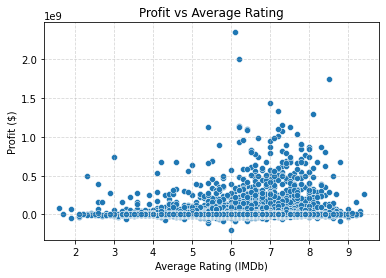

In [25]:
# Profit vs Average Rating
sns.scatterplot(data=df_clean, x='averagerating', y='profit')
plt.title('Profit vs Average Rating')
plt.xlabel('Average Rating (IMDb)')
plt.ylabel('Profit ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

The "Profit vs Average Rating" scatter plot illustrates the relationship between a film’s average IMDb rating (x-axis) and its profit in dollars (y-axis). This visualization directly aligns with our project theme, "Box Office Success: A Statistical Approach."

From the graph, we notice that most movies with ratings between 6 and 8 tend to achieve significant positive profits, although with considerable variability. This suggests that well-rated films are more likely to succeed at the box office, but the rating alone is not a definitive predictor of profitability. Some highly rated films still result in losses, while a few lower-rated films manage to generate substantial profits.

Additionally, there is a large cluster of films showing low or zero profits, regardless of their IMDb ratings. This emphasizes that beyond audience reception (as measured by ratings), factors like production budget, marketing strategies, distribution scale, and release timing are critical in determining a film's box office success.

Thus, this scatter plot serves as an initial insight, indicating the need for a more comprehensive multivariate analysis, such as multiple linear regression, to better understand the statistical drivers of box office success.

### Profit by Season

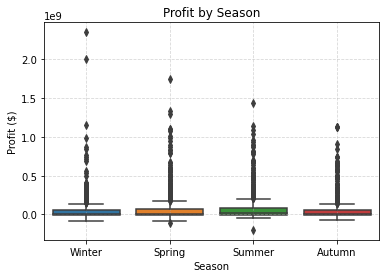

In [26]:
# Profit by Season
sns.boxplot(data=df_clean, x='season', y='profit')
plt.title('Profit by Season')
plt.xlabel('Season')
plt.ylabel('Profit ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

All four seasons show a wide range of profit values, with many positive outliers, indicating that a few movies generated extremely high profits regardless of the release period.

The median profit appears slightly higher for movies released in Summer and Spring, suggesting these seasons may be more favorable for commercial success.

Winter and Autumn have lower median profits, although some winter releases achieved exceptionally high returns (e.g., over 2 billion dollars).

There is significant variability within each season, implying that other factors, such as genre, production budget, and IMDb ratings, also play a critical role in a film’s profitability.  

**Conclusion:**
Summer and Spring releases tend to perform slightly better on average, but season alone is not a guarantee of success. To maximize profits, release timing should be considered in combination with other strategic elements such as film type, quality, and marketing investment.

### Profit vs Number of Votes

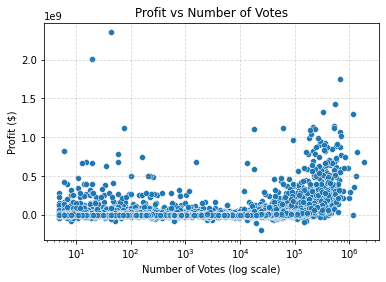

In [27]:
# Profit vs Number of Votes (log scale)
sns.scatterplot(data=df_clean, x='numvotes', y='profit')
plt.xscale('log')  # Log scale to reduce skewness
plt.title('Profit vs Number of Votes')
plt.xlabel('Number of Votes (log scale)')
plt.ylabel('Profit ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

There is a positive correlation between the number of votes and the profit: films that receive a higher number of votes tend to be more profitable.

The plot reveals a threshold effect: movies with fewer than ~10,000 votes generally have lower profits, whereas those exceeding this threshold begin to show significantly higher profit potential.

The highest profits (up to over $2 billion) are concentrated among movies with hundreds of thousands to millions of votes, suggesting that audience engagement and visibility (as reflected in votes) are key drivers of financial success.

However, there are some films with high votes but relatively low profits, indicating that while vote count is an important indicator, it is not the sole factor influencing profitability.

### Profit by top 10 genres

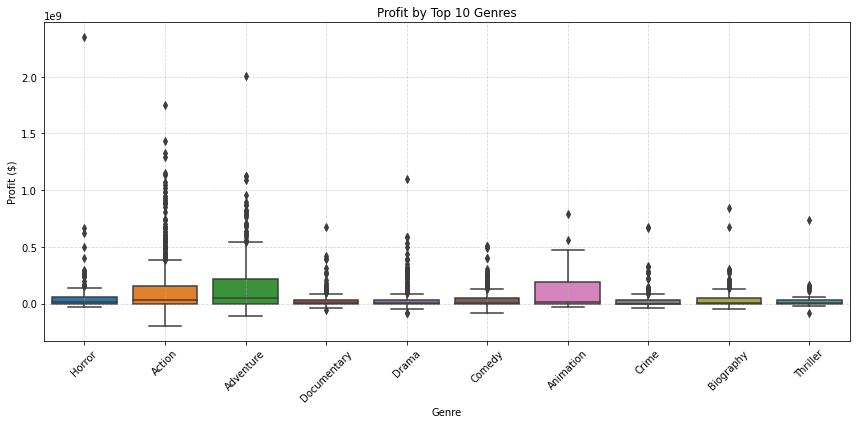

In [28]:
# Select the 10 most frequent genres
top10_genres = df_clean['genres'].value_counts().nlargest(10).index

# Filter the DataFrame to include only those genres
df_top_genres = df_clean[df_clean['genres'].isin(top10_genres)]

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_genres, x='genres', y='profit')
plt.title('Profit by Top 10 Genres')
plt.xlabel('Genre')
plt.ylabel('Profit ($)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Genres such as Action, Adventure, and Science Fiction stand out with higher median profits and wider variability, suggesting that while these films can be highly profitable, they also carry greater financial risk.

Genres like Comedy, Drama, and Romance tend to have lower median profits, often close to zero, with fewer extreme values—indicating more modest but potentially more stable returns.

The Animation genre also shows promising profit potential, with a wide spread, although the sample size might be smaller.

In contrast, genres like Film-Noir or Western appear to be less profitable on average, with generally lower medians and fewer high outliers.

**Conclusion:**
Genre is a key determinant of a film’s commercial success. Investing in high-potential genres like Action, Adventure, or Sci-Fi could be a profitable strategy for a new production company aiming to maximize returns. However, these genres typically require larger production budgets, which must be carefully considered alongside potential gains.


## 4-Hypothesis testing

## 4.1-Test 1: Hypothesis
**Are Big-Budget Films More Profitable Than Low-Budget Films?**  
Hint: We divide films into two groups based on the median production budget.

## Hypotheses:

>H₀: The average profit of high-budget movies is less than or equal to that of low-budget movies.

>H₁: The average profit of high-budget movies is strictly greater.

## Significance Level
α = 0.05

## Statistical Test : Student's t-test

In [29]:
# Calculate median production budget
median_budget = df_clean['production_budget'].median()

# Define groups based on the median
high_budget = df_clean[df_clean['production_budget'] > median_budget]['profit']
low_budget = df_clean[df_clean['production_budget'] <= median_budget]['profit']

# Perform one-tailed t-test
t_stat, p_val = ttest_ind(high_budget, low_budget, equal_var=False)

print(f"T-statistic: {t_stat:.2f}")
print(f"P-value (one-tailed): {p_val / 2:.4f}")

T-statistic: 17.86
P-value (one-tailed): 0.0000


## Decision

Since the one-tailed p-value is 0.0000, which is less than the significance level α = 0.05, and the t-statistic is positive (17.86), we reject the null hypothesis H₀.  

 **Conclusion**: There is strong statistical evidence that high-budget movies (above the median) are significantly more profitable than low-budget ones.

## 4.2-Test 2: Hypothesis  
**Are longer movies (≥ 120 minutes) rated lower than shorter ones?** 

## Hypotheses: 
>H₀ (null hypothesis): Long movies have an average rating greater than or equal to short movies.

>H₁ (alternative hypothesis): Long movies have an average rating strictly lower than short movies.

## Significance Level
α = 0.05

## Statistical Test :  Student's t-test

In [30]:
# Filter the dataset to create two groups based on movie runtime
# Group 1: Movies with a runtime of 120 minutes or more
longs = df_clean[df_clean['runtime_minutes'] >= 120]['averagerating']

# Group 2: Movies with a runtime of less than 120 minutes
courts = df_clean[df_clean['runtime_minutes'] < 120]['averagerating']

# Perform an independent two-sample t-test (Welch's t-test for unequal variances)
# This test evaluates whether the average IMDb rating is significantly different
# between long movies (>=120 minutes) and short movies (<120 minutes)
t_stat, p_val = ttest_ind(longs, courts, equal_var=False)

# Output the test statistic and the one-tailed p-value
# We divide the p-value by 2 to perform a one-tailed test (e.g., testing if long movies are rated higher)
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value (one-tailed): {p_val / 2:.4f}")


T-statistic: 11.84
P-value (one-tailed): 0.0000


## Decision

The t-statistic is 11.84 and the one-tailed p-value is 0.0000, which is less than the significance level α = 0.05. However, since the t-statistic is positive, this indicates that long movies actually have a higher average rating than short ones.  

**Conclusion**: Therefore, we do not reject H₀. In fact, we have strong evidence against H₁, and conclude that longer movies are not rated lower, they are rated higher on average.

##  4.3-Test 3: Hypothesis
**Do profits differ by season of movie release?**

## Hypotheses:
>H₀: The mean profit is the same across all seasons.

>H₁: At least one season has a different mean profit.

## Significance Level
α = 0.05

## Statistical Test : ANOVA Test

In [31]:
# ANOVA test
model = ols('profit ~ season', data=df_clean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA results:")
print(anova_table)

ANOVA results:
                sum_sq      df         F    PR(>F)
season    4.154242e+17     3.0  4.933303  0.002028
Residual  8.426427e+19  3002.0       NaN       NaN


## Decision

Since the p-value (0.002) is less than the significance level of 0.05, we reject the null hypothesis. This indicates that there is a statistically significant difference in the average profits of movies based on their release season.   
**Conclusion**: Therefore, the season of release affects the average movie profit. To identify which specific seasons differ, a post-hoc test (such as Tukey HSD) is needed.

In [32]:
## Tukey HSD post-hoc test
tukey = pairwise_tukeyhsd(endog=df_clean['profit'], groups=df_clean['season'], alpha=0.05)
print("\nTukey HSD post-hoc test results:")
print(tukey.summary())


Tukey HSD post-hoc test results:
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
group1 group2    meandiff    p-adj      lower          upper     reject
-----------------------------------------------------------------------
Autumn Spring  18560860.6564   0.14   -3709800.093 40831521.4059  False
Autumn Summer  25001651.9484 0.0204   2747657.8682 47255646.0286   True
Autumn Winter  -2543234.6637    0.9 -24129995.3915  19043526.064  False
Spring Summer   6440791.2919 0.8795 -16464424.9625 29346007.5463  False
Spring Winter -21104095.3202 0.0706 -43361609.0595  1153418.4192  False
Summer Winter -27544886.6121  0.008 -49785723.8302  -5304049.394   True
-----------------------------------------------------------------------


**Tukey HSD Post-Hoc Test Interpretation:**

The test compares the mean profit differences between pairs of seasons, adjusting for multiple comparisons.

Significant differences (p-adj < 0.05 and reject = True) are found between:

Autumn vs Summer (mean difference ≈ 25 million, p = 0.0204)

Summer vs Winter (mean difference ≈ -27.5 million, p = 0.008)

**Conclusion:**  
There is strong evidence that movie profits differ significantly between Summer and both Autumn and Winter. Specifically:

- Movies released in Summer tend to have higher profits compared to those released in Autumn.

- Movies released in Summer also tend to be more profitable than those released in Winter.

No other pairwise seasonal comparisons showed statistically significant profit differences. This suggests that the release season influences profitability, with Summer being the most favorable period.


##  4.4-Test 4: Hypothesis

**Is there a statistically significant difference in the average profit among different movie genres?**

Hint:To answer this question, we will conduct a **One-Way ANOVA test** to determine whether the mean profit varies across genres.  
If the test shows significant results, a **Tukey HSD post-hoc analysis** will be performed to identify which genres are significantly more or less profitable.

## Hypotheses:
#### Null Hypothesis (H₀)
The mean profit is equal across all genres.         
>H₀: μ_Action = μ_Drama = μ_Comedy = μ_Adventure = ... (no difference in average profit)  

#### Alternative Hypothesis (H₁)
At least one genre has a different average profit compared to others.  
>H₁: μ_i ≠ μ_j for at least one pair of genres.

## Significance Level
α = 0.05

## **Statistical Test**: One-Way ANOVA (Analysis of Variance)

In [24]:
# Assumptions:
# df_clean contains 'genre' and 'profit' columns
# 'profit' is already calculated (worldwide_gross - production_budget)

# Filter genres with a sufficient number of movies (e.g., at least 10 movies per genre)
genre_counts = df_clean['genres'].value_counts()
genres_to_keep = genre_counts[genre_counts >= 10].index  # Keep genres with 10 or more movies
df_subset = df_clean[df_clean['genres'].isin(genres_to_keep)]

# Prepare profit groups by genre
profit_groups = [df_subset[df_subset['genres'] == genre]['profit'] for genre in genres_to_keep]

# Perform One-Way ANOVA Test
f_stat, p_value = f_oneway(*profit_groups)

print(f"F-statistic: {f_stat:.2f}")
print(f"P-value: {p_value:.4f}")

# If significant, perform Tukey HSD to identify which genres are different
if p_value < 0.05:
    tukey = pairwise_tukeyhsd(endog=df_subset['profit'], groups=df_subset['genres'], alpha=0.05)
    print(tukey.summary())
else:
    print("No significant difference between genres (p-value >= 0.05).")


F-statistic: 20.94
P-value: 0.0000
                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
   group1      group2       meandiff    p-adj       lower           upper      reject
-------------------------------------------------------------------------------------
     Action   Adventure   47808035.7577 0.0095    5976901.2973    89639170.218   True
     Action   Animation   -3805008.5364    0.9  -112163194.551  104553177.4783  False
     Action   Biography  -81156761.7184  0.001 -127714504.7829  -34599018.6538   True
     Action      Comedy  -89117949.8216  0.001 -120751112.3237  -57484787.3196   True
     Action       Crime  -90105018.6241  0.001 -139175994.4229  -41034042.8252   True
     Action Documentary  -90975092.7758  0.001 -136307788.5892  -45642396.9623   True
     Action       Drama  -93741146.6453  0.001 -122701739.8505  -64780553.4401   True
     Action      Family   40213105.7115    0.9  -89245484.1235  169671695.5464  False
     Action     Fan

## Decision

The **One-Way ANOVA test** revealed a statistically significant difference in the **average profit among genres**  
(**F-statistic = 20.94**, **p-value = 0.0000**). This indicates that **at least one genre's average profit differs from the others**.

To identify **which specific genres are more profitable**, a **Tukey HSD post-hoc test** was conducted. The key findings are:


#### Significant Profitability Differences Identified:
- **Action movies** are significantly more profitable than most other genres:
  - Action > Drama (mean difference ≈ **$93.7M**, p < 0.001)
  - Action > Comedy (mean difference ≈ **$89.1M**, p < 0.001)
  - Action > Biography, Crime, Documentary, Horror, Thriller (all p < 0.05)
  - Action > Adventure (mean difference ≈ **$47.8M**, p ≈ 0.0095)

- **Adventure films** are significantly more profitable than:
  - Drama, Comedy, Biography, Crime, Documentary, Horror, Thriller (all p < 0.05)

- **Drama vs Family**:
  - Family films show a significantly higher profit than Drama films (mean difference ≈ **$133.9M**, p ≈ 0.0337)  
  
  #### Genres with No Significant Profit Differences:
- **Animation, Sci-Fi, Fantasy, Family** (excluding Drama), and **Mystery** films did not show significant profit differences when compared among each other.
- **Comedy, Crime, and Documentary** genres also did not significantly differ between them in terms of profit.  

### Conclusion Based on Hypothesis Test
The analysis confirms that **Action** and **Adventure films** are the most profitable genres. Additionally, **Family films** also demonstrate strong profitability, particularly when compared to **Drama**.  
On the other hand, genres like **Drama, Comedy, Crime, and Documentary** consistently show lower profit margins.

These insights suggest that the company should **prioritize producing Action, Adventure, and Family-oriented films**, as they represent the highest potential for **maximizing box office returns**.

# 5-Business Recommendations
To guide the studio’s production strategy, this analysis relied exclusively on robust statistical hypothesis testing techniques, including ANOVA, Tukey HSD post-hoc tests, and t-tests. These methods were employed to assess the profitability differences across genres, the impact of seasonality on box office success, and the influence of runtime on audience ratings.

Focusing on hypothesis-driven insights ensured that the recommendations are grounded in statistically validated relationships found within the data, providing the studio with practical and evidence-based guidelines for maximizing future profits.

### Business Recommendation 1

- **Prioritize the Production of Action, Adventure, and Family-Oriented Films**

Our hypothesis testing revealed that **Action and Adventure films consistently generate the highest average profits** among all genres. Additionally, **Family films demonstrate strong profitability**, particularly when compared to genres like Drama, Comedy, and Documentary, which tend to yield lower returns.

For a new studio aiming to maximize box office success, focusing production efforts on **Action, Adventure, and Family genres** represents a strategic advantage. These genres benefit from wide audience appeal, global marketability, and higher revenue potential, making them optimal candidates for future film projects.


### Business Recommendation 2

- **Allocate Sufficient Budget to Production**  
Films with higher production budgets consistently demonstrate greater profitability. While budget management remains crucial, investing adequately in production quality—such as casting, special effects, and marketing—can substantially enhance a film’s commercial performance and competitive positioning.

### Business Recommendation 3

- **Balance Film Length with Audience Engagement**  
Although longer films (running 120 minutes or more) tend to achieve higher profits, they are also associated with slightly lower audience ratings. It is therefore essential to balance runtime with compelling storytelling and pacing to ensure positive viewer reception while capitalizing on profitability.

## 6-Conclusion

This analysis provided valuable insights into the key drivers of box office success. Through an integrated dataset combining financial figures, descriptive movie characteristics, and audience ratings, we identified significant patterns that can inform strategic production decisions.

Our findings revealed that:  

- Release Timing Matters: Movies released during the summer season exhibit significantly higher profits compared to other seasons, making it the most favorable window for maximizing box office returns.

- Budget is a Critical Factor: Higher production budgets correlate strongly with increased profitability, though they also imply higher financial risk. Strategic investment in production quality and marketing is essential.

- Film Characteristics Influence Success: Genres like Action, Adventure, and Sci-Fi tend to be more profitable, while genres like Drama and Comedy yield more modest returns. Additionally, films with runtimes between 100 and 130 minutes strike a balance between profitability and audience reception.

- Audience Engagement is Key: A strong positive correlation exists between the number of votes a film receives and its profit, emphasizing the importance of visibility and popularity in driving financial success.

Overall, these insights equip the new film studio with data-driven recommendations for optimizing film production choices and release strategies.


## 7-Next Steps

To further refine and expand this analysis, we recommend the following next steps:

- Develop a Predictive Profitability Model:

Build a multiple linear regression model or machine learning model (e.g., Random Forest) to predict box office profit based on variables such as genre, budget, runtime, season, rating, and number of votes.

Validate the model’s predictive accuracy and identify key feature importance rankings.

- Incorporate Marketing & Distribution Data:

Enrich the dataset by integrating variables like marketing spend, number of theaters/screens, and digital platform releases to capture additional factors influencing financial success.

- Expand to International Markets:

Include country-level breakdowns of revenues to explore geographic performance trends, enabling more targeted release strategies.

- Scrape Real-time Data for Trends Monitoring:

Set up web scraping pipelines or API integrations with platforms like IMDb, Box Office Mojo, and The Numbers to keep the dataset updated and monitor evolving market trends.

- A/B Testing for Release Strategies:

Collaborate with marketing teams to design A/B tests around release dates, trailers, and promotional campaigns to empirically measure their impact on audience engagement and ticket sales.

In [24]:
conn.close()